In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import plotly.graph_objects as go
import seaborn as sb
sb.set()

import constants as c
import requests

In [2]:
def getIndicator(indicator, stock, date_from=None, date_until=None, timespan='day', adjusted=True, window=50, short_window=12, long_window=26, signal_window=9, series_type='close', expand_underlying=False, order='desc', limit=5000, apiKey=c.POLY_APIKEY):
    indicator = indicator.lower()
    stock = stock.upper()

    if indicator not in ['sma', 'ema', 'macd', 'rsi']:
        print('Indicator not found!')
        return None
    
    url = f'https://api.polygon.io/v1/indicators/{indicator}/{stock}'
    params = {
        'timestamp.gte': date_from,
        'timestamp.lte': date_until,
        'timespan': timespan,
        'adjusted': adjusted,
        'series_type': series_type,
        'expand_underlying': expand_underlying,
        'order': order,
        'limit': limit,
        'apiKey': apiKey,
    }

    if indicator == 'macd':
        params['short_window'] = short_window
        params['long_window'] = long_window
        params['signal_window'] = signal_window
    else:
        params['window'] = window

    try:
        response = requests.get(url=url, params=params)
        values = response.json()['results']['values']
        return values
    except:
        print("Stock not found!")
        return None

In [3]:
stock = 'aapl'
date_from = '2021-12-01'
date_until = '2023-02-01'

sma_window = 50  # num of days
sma_df = pd.DataFrame(getIndicator('sma', stock=stock, window=sma_window, date_from=date_from, date_until=date_until))
sma_df.rename({'value': 'sma_value'}, axis='columns', inplace=True)

ema_window = 50  # num of days
ema_df = pd.DataFrame(getIndicator('ema', stock=stock, window=sma_window, date_from=date_from, date_until=date_until))
ema_df.rename({'value': 'ema_value'}, axis='columns', inplace=True)

macd_df = pd.DataFrame(getIndicator('macd', stock=stock, date_from=date_from, date_until=date_until))
macd_df.rename(columns={'value': 'macd_value', 'signal':'macd_signal', 'histogram': 'macd_histogram'}, inplace=True)

rsi_df = pd.DataFrame(getIndicator('rsi', stock=stock, date_from=date_from, date_until=date_until))
rsi_df.rename(columns={'value': 'rsi_value'}, inplace=True)

indicators_df = sma_df
for item in [ema_df, macd_df, rsi_df]:
    indicators_df = indicators_df.merge(item, 'inner', 'timestamp')
indicators_df['date'] = pd.to_datetime(indicators_df['timestamp'], unit='ms')
indicators_df

,timestamp,sma_value,ema_value,macd_value,macd_signal,macd_histogram,rsi_value,date
0,1675227600000,138.7700,139.304925,2.539966,1.210677,1.329289,51.259983,2023-02-01 05:00:00
1,1675141200000,138.8758,139.054922,2.322118,0.878355,1.443763,50.770006,2023-01-31 05:00:00
2,1675054800000,138.9658,138.841246,2.126361,0.517414,1.608947,50.214997,2023-01-30 05:00:00
3,1674795600000,139.1066,138.671500,1.976921,0.115177,1.861744,51.507539,2023-01-27 05:00:00
4,1674709200000,139.1536,138.375235,1.459098,-0.350259,1.809357,50.670898,2023-01-26 05:00:00
...,...,...,...,...,...,...,...,...
289,1638853200000,150.9864,153.979840,4.505394,3.698291,0.807103,63.838543,2021-12-07 05:00:00
290,1638766800000,150.4702,153.277793,3.990402,3.496516,0.493886,61.087361,2021-12-06 05:00:00
291,1638507600000,150.1022,152.786274,3.871696,3.373044,0.498652,59.284593,2021-12-03 05:00:00
292,1638421200000,149.8020,152.416734,4.018197,3.248381,0.769816,60.807791,2021-12-02 05:00:00


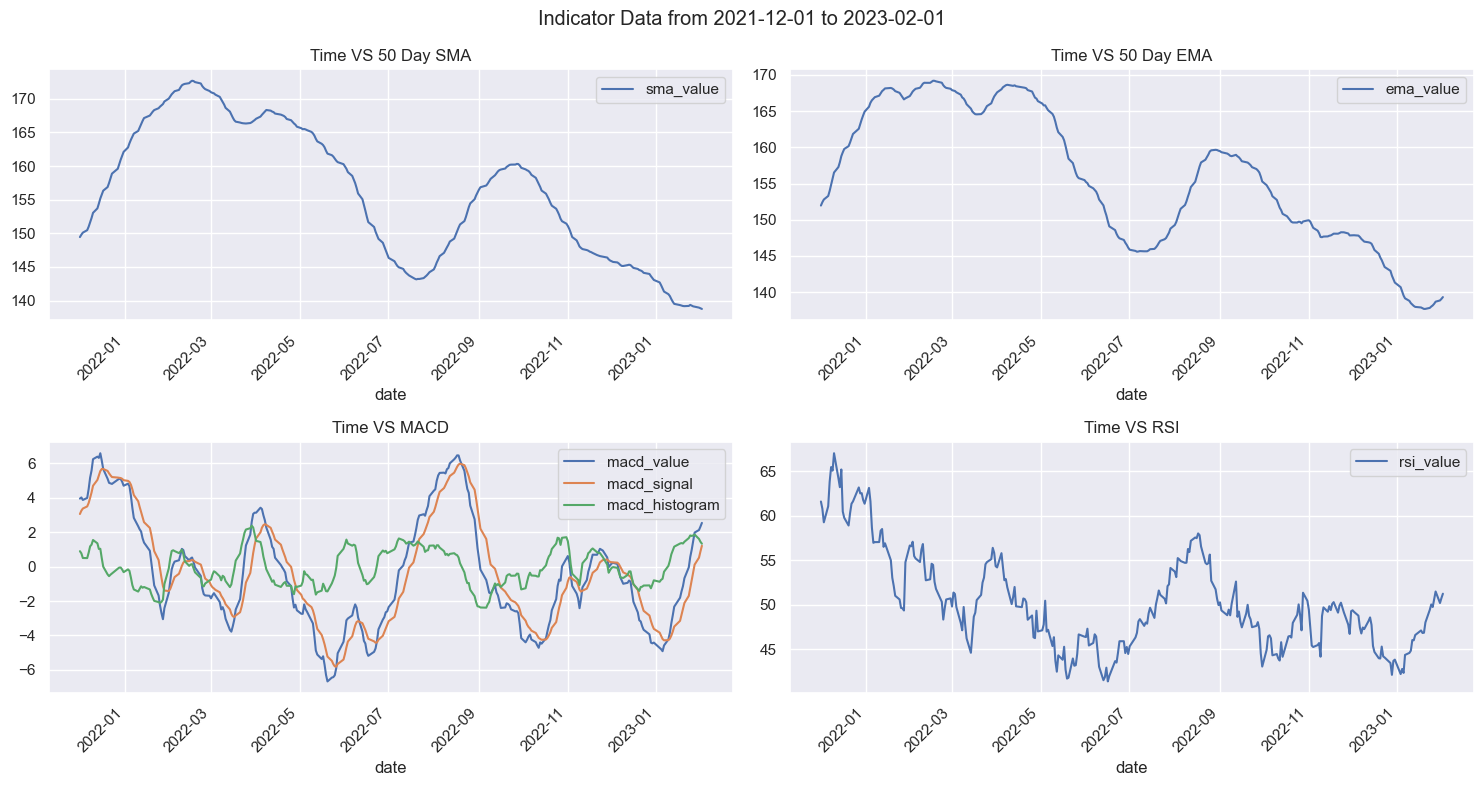

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
indicators_df.plot(x='date', y='sma_value', title=f"Time VS {sma_window} Day SMA", ax=ax[0][0], rot=45)
indicators_df.plot(x='date', y='ema_value', title=f"Time VS {ema_window} Day EMA", ax=ax[0][1], rot=45)
indicators_df.plot(x='date', y=['macd_value', 'macd_signal', 'macd_histogram'], title="Time VS MACD", ax=ax[1][0], rot=45)
indicators_df.plot(x='date', y='rsi_value', title="Time VS RSI", ax=ax[1][1], rot=45)
fig.suptitle(f'Indicator Data from {date_from} to {date_until}')
fig.tight_layout();